In [1]:
import requests
import json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [44]:
from wordcloud import WordCloud

## Llamada a la API para obtener todos los dialogos.

In [3]:
url = "http://127.0.0.1:5000/"
#GET

endpoint_user = "users"
endopoint_message= "messages"
endopoint_user_message= "<episode>/<name>"

In [4]:
mess = requests.get(url + endopoint_message).json()
mess[:5]

[{'Episode': '1',
  'Character': 'Stan',
  'Line': 'You guys, you guys! Chef is going away.'},
 {'Episode': '1', 'Character': 'Kyle', 'Line': 'Going away? For how long'},
 {'Episode': '1', 'Character': 'Stan', 'Line': 'Forever'},
 {'Episode': '1', 'Character': 'Chef', 'Line': "I'm sorry boys"},
 {'Episode': '1',
  'Character': 'Stan',
  'Line': "Chef said he's been bored, so he joining a group called the Super Adventure Club."}]

### Hacemos un dataframe con ello.

In [5]:
data = pd.DataFrame(mess)

In [6]:
data.head()

,Episode,Character,Line
0,1,Stan,"You guys, you guys! Chef is going away."
1,1,Kyle,Going away? For how long
2,1,Stan,Forever
3,1,Chef,I'm sorry boys
4,1,Stan,"Chef said he's been bored, so he joining a gro..."


### Aplicamos Stop Words de NLTK para deshacernos de las palabras neutras.

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/a.m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
#stopwords.words('english')

In [9]:
data["Line"] = data["Line"].astype(str)

data.head()

,Episode,Character,Line
0,1,Stan,"You guys, you guys! Chef is going away."
1,1,Kyle,Going away? For how long
2,1,Stan,Forever
3,1,Chef,I'm sorry boys
4,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [10]:
data.Line = data.Line.apply(lambda x: x.split(" "))
data.head()

,Episode,Character,Line
0,1,Stan,"[You, guys,, you, guys!, Chef, is, going, away.]"
1,1,Kyle,"[Going, away?, For, how, long]"
2,1,Stan,[Forever]
3,1,Chef,"[I'm, sorry, boys]"
4,1,Stan,"[Chef, said, he's, been, bored,, so, he, joini..."


In [11]:
def stop_words (lista):
    stop_words = set(stopwords.words('english'))
    nueva_lista = []
    for string in lista:
        if string.lower() not in stop_words:
            nueva_lista.append(string)
    return " ".join(nueva_lista)

In [12]:
data.Line = data.Line.apply(stop_words)
data.head()

,Episode,Character,Line
0,1,Stan,"guys, guys! Chef going away."
1,1,Kyle,Going away? long
2,1,Stan,Forever
3,1,Chef,I'm sorry boys
4,1,Stan,"Chef said he's bored, joining group called Sup..."


## Realizamos Sentiment Analysis con Vader Lexicon de NLTK 

In [13]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/a.m/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [14]:
def sentimentAnalysis(sentence):
    sia = SentimentIntensityAnalyzer()
    polarity = sia.polarity_scores(sentence)
    pol = polarity['compound']
    return pol

In [15]:
data['sentiment_compound'] = data.Line.apply(sentimentAnalysis)
data.head()

,Episode,Character,Line,sentiment_compound
0,1,Stan,"guys, guys! Chef going away.",0.0000
1,1,Kyle,Going away? long,0.0000
2,1,Stan,Forever,0.0000
3,1,Chef,I'm sorry boys,-0.0772
4,1,Stan,"Chef said he's bored, joining group called Sup...",0.6249


In [16]:
resumen = data.groupby(['Character'])['sentiment_compound'].mean().sort_values()
#resumen

In [17]:
tail_5 = resumen[:5]
tail_5

Character
Darryl           -0.8271
Attendant        -0.6808
Network Anchor   -0.6808
Michael          -0.5848
Tom              -0.3825
Name: sentiment_compound, dtype: float64

### Darryl es quien obtiene la peor puntuación al analizar los 3 primeros capitulos de la temporada 10.

<AxesSubplot:xlabel='Character'>

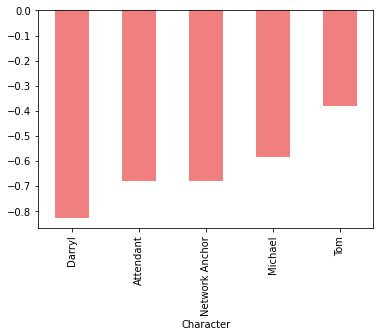

In [41]:
tail_5.plot(kind="bar", color= "lightcoral")

In [19]:
top_5 = resumen[-5:]
top_5

Character
Speaker       0.541100
Townsfolk     0.624900
Keenan        0.636633
Anchor Tom    0.670500
Gail          0.749600
Name: sentiment_compound, dtype: float64

### Townsfolf es quien obtiene la mejor puntuación al analizar los 3 primeros capitulos de la temporada 10. Entendemos que el Speaker es el narrador de los capitulos.

<AxesSubplot:xlabel='Character'>

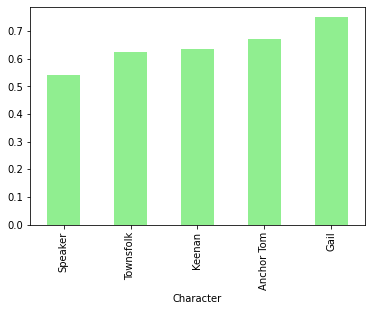

In [35]:
top_5.plot(kind="bar", color = "lightgreen")

## Creamos dataframe solo con los 4 protagonistas.

In [21]:
resumen = pd.DataFrame(resumen)
#resumen

In [23]:
resumen['protas'] = resumen.index

In [24]:
resumen2 = resumen[(resumen["protas"]== "Cartman")| (resumen["protas"]== "Kenny") | (resumen["protas"]== "Kyle") | (resumen["protas"]== "Stan") ]

In [25]:
resumen2

,sentiment_compound,protas
Character,,
Kenny,0.000000,Kenny
Cartman,0.009222,Cartman
Stan,0.055028,Stan
Kyle,0.097019,Kyle


### Todos los protagonistas obtienen un analisis neutro, todos los valores muy ceca del cero. 

<AxesSubplot:xlabel='protas', ylabel='sentiment_compound'>

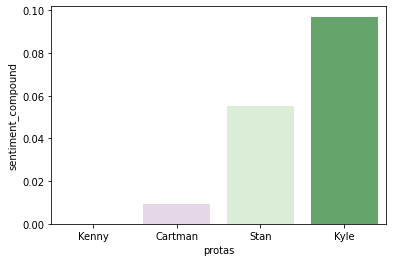

In [40]:
sns.barplot(
    x = resumen2["protas"],
    y = resumen2["sentiment_compound"],
    palette= "PRGn"
)

### Analisis con WordCloud para ver cuales son las palabras más utilizadas.

In [56]:
df_protas = data[(data["Character"]== "Cartman")| (data["Character"]== "Kenny") | (data["Character"]== "Kyle") | (data["Character"]== "Stan") ]

In [57]:
df_protas.head()

,Episode,Character,Line,sentiment_compound
0,1,Stan,"guys, guys! Chef going away.",0.0000
1,1,Kyle,Going away? long,0.0000
2,1,Stan,Forever,0.0000
4,1,Stan,"Chef said he's bored, joining group called Sup...",0.6249
9,1,Cartman,I'm gonna miss him. I'm gonna miss Chef I...a...,-0.3595


In [94]:
def generateWordCloud(data,title):
    wordcloud = WordCloud(background_color='black',
        colormap= 'Set2',
        max_words=500,
        max_font_size=50, 
        scale=5,
        random_state=3).generate(str(data))


    wordcloud.recolor(random_state=1)
    plt.figure(figsize=(15,15))
    plt.title(title, fontsize=20,color='black')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

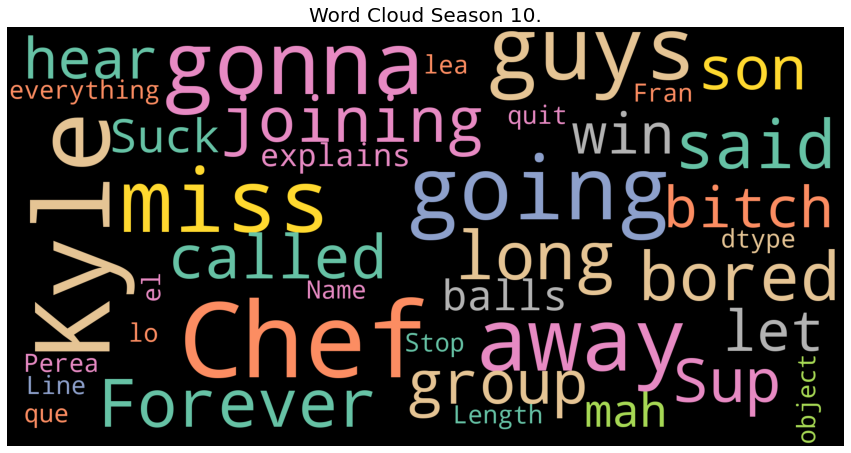

In [95]:
 generateWordCloud(df_protas['Line'],"Word Cloud Season 10.")